# Zoidberg 2.0

We were given a dataset of x-rays, which took around 20 minutes to install from their server. To speed things up and for convenience we sanitized the dataset and uploaded it to hugging face hub. We will see how fast and concise this solution turned out to be. 

Our goal with the dataset is to find the right machine learning model to help doctors in detecting pneumonia. We will proceed by pulling the `train` split of the dataset (as you can see with the `split="train"` parameter).

In [4]:
from datasets import load_dataset

dataset = load_dataset("Az-r-ow/chest_xray", split="train")

/Users/az-r-ow/Developer/zoidberg/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from PIL import Image
from io import BytesIO

def format_dataset(dataset):
  pd_dataset = dataset.to_pandas()
  pd_dataset['true_label'] = pd_dataset['label'].map(lambda x: "NORMAL" if x == 0 else "PNEUMONIA")
  pd_dataset['image'] = pd_dataset['image'].map(lambda i: Image.open(BytesIO(i["bytes"])))
  return pd_dataset

# Converting to pandas will encode the images to bytestrings
train_data = format_dataset(dataset)
train_data.head()

,image,label,true_label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL


Now that we have our data ready, we can start by checking the number of image per `class`. 

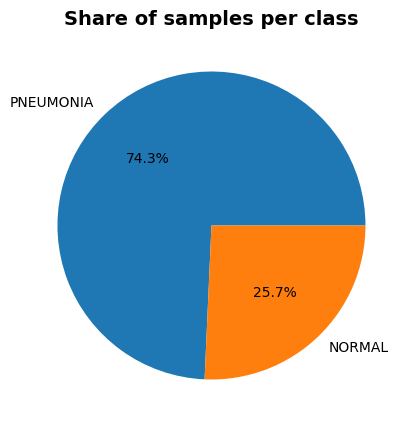

In [6]:
from matplotlib import pyplot as plt

def plot_value_counts(df, col_name, plot_title=""):
  """
  Plot the value counts of a column in a DataFrame.

  Parameters:
  -----------
  df : pandas DataFrame
      The DataFrame containing the column to plot.

  col_name : str
      The name of the column in the DataFrame for which to plot the value counts.

  plot_title : str, optional
      Title of the plot. Default is an empty string.

  Returns:
  --------
  None
  """
  class_counts = df[col_name].value_counts()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
  ax.set_title(plot_title, fontsize=14, fontweight="bold")

plot_value_counts(train_data, 'true_label', "Share of samples per class")

We can clearly see an imbalance between the two classes and that's something to keep in mind as it might lead any model towards over-fitting in favor of `infected` (for instances with label `1`).  

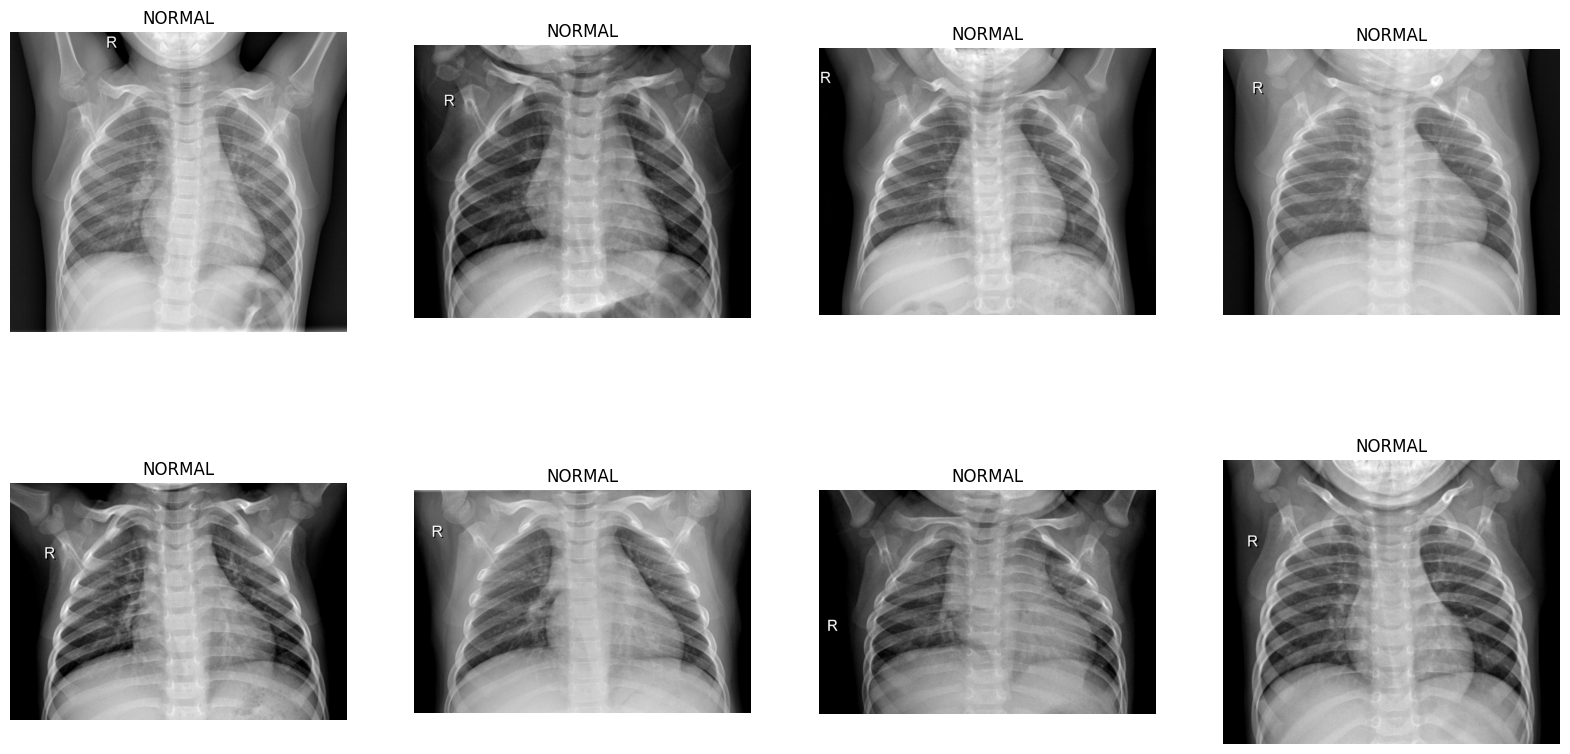

In [40]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd

def get_center_crop_coord(image, target_size=(100, 100)):
  """
  Calculates the coordinates for center cropping an image to the specified target size.
  
  Parameters:
      image (PIL.Image.Image): The input image to be center cropped.
      target_size (tuple): A tuple specifying the target size (width, height) for the cropped region.
  
  Returns:
      tuple: A tuple containing the coordinates (x, y, width, height) for center cropping the image.
  """
  width, height = image.size
  crop_x = (width - target_size[0]) // 2
  crop_y =  (height - target_size[1]) // 2
  return (crop_x, crop_y, crop_x + target_size[0], crop_y + target_size[1])

# Displaying the images
def display_images(data, rows, columns, crop_area=None):
  if (len(data) < (rows * columns)):
    raise ValueError(f"Length data should be > than (rows * columns) we got : {rows * columns} and data length = {len(data)}")
  fig, axes = plt.subplots(rows, columns, figsize=(20, 10))
  for i, ax in enumerate(axes.flat):
    image = data[i] if not isinstance(data, pd.DataFrame) else data["image"][i]
    label = "" if not isinstance(data, pd.DataFrame) else data["true_label"][i]
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    
    if crop_area:
      x, y, width, height = crop_area = get_center_crop_coord(image, crop_area)
      print(f"x: {x}, y: {y}, width: {width}, height: {height}")
      print(f"Image height: {image.height}, width: {image.width}")
      rect = patches.Rectangle((x, y), crop_area[0], crop_area[1], linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      
    ax.axis('off')
  plt.show()
  
display_images(train_data, 2, 4)


## Class Imbalance

### Problem 

As we saw earlier in the pie chart, we have 3 times the number of x-rays of chests with `PNEUMONIA`. That will to a biased model with misleading accuracy. For example if we implement a model that only predicts `1` we will get 74.2% accuracy during training. But that goes AGAINST the goal of **generalization** that we want to achieve. 

### Solutions

How can we proceed with this ?

- **Undersampling**
  
- **Oversampling** 
  
- **Performance Metrics**

Let's go through some more details. 

- **Undersampling** we will reduce the training set of $20\%$ which is not a lot considering that the difference between the two classes. This will result in the dataset consisting of $2712$ `PNEUMONIA` rows and $4053$ in total. Performing this operation will reduce the gap between the classes from $49\%$ to $39\%$. But not to worry, it will go down even more with **oversampling**.
  
- **Oversampling** we will increase the number of `NORMAL` samples by $20\%$ by randomly duplicating rows, the number being reasonable is enough to reduce the gap between the two classes yet not creating a lot of duplication which might corrupt the learning. 
  By doing so we'll be able to reduce the gap to $25\%$.

- **Performance Metrics** when the time comes we'll use the metric that either minimizes false positives or false negatives based on the observations.


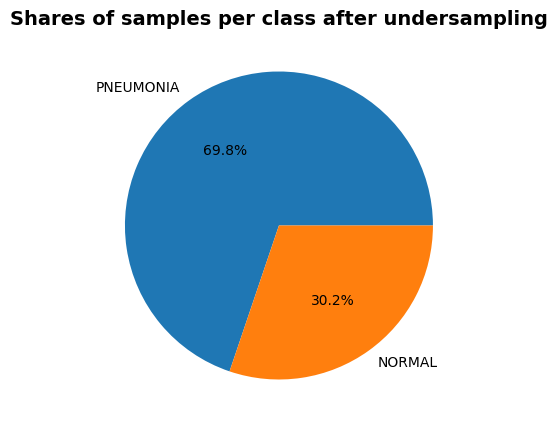

In [8]:
import pandas as pd

def undersample(df, true_label, frac):
  """
  Undersamples a DataFrame by reducing the number of samples for a specific class.

  Parameters:
  -----------
  df : pandas DataFrame
      The DataFrame containing the dataset to be undersampled.

  true_label : str
      The true label of the class for which to perform undersampling.

  rate : float or int
      The desired ratio of samples to retain for the specified class after undersampling.
      If float, it represents the fraction of samples to retain (0.0 to 1.0).
      If int, it represents the absolute number of samples to retain.

  Returns:
  --------
  pandas DataFrame
      The undersampled DataFrame with reduced number of samples for the specified class.

  Example:
  --------
  undersampled_df = undersample(df, 'class', 0.5)
  """
  undersampled_df = pd.concat([
    df[df["true_label"] != true_label], 
    df[df["true_label"] == true_label].sample(frac=frac)
  ])
  return undersampled_df.reset_index(drop=True)

balanced_train_data = undersample(train_data, "PNEUMONIA", 0.8) # Retaining 80% of the samples

plot_value_counts(balanced_train_data, 'true_label', "Shares of samples per class after undersampling")

Things went as expected the gap between the two classes is not sitting at $39.6\%$ and will be going down even further with oversampling. We want to note that we purposely did not override the `train_data` variable to keep it as a backup in case our results are corrupted and we want to go back to the initial dataset. 

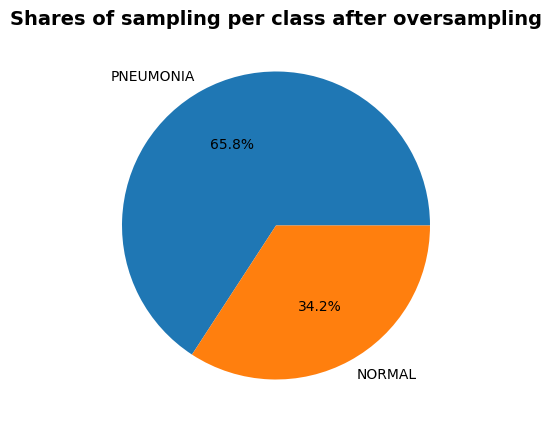

In [9]:
import math

def oversample(df, true_label, frac):
  """
  Oversamples a DataFrame by randomly duplicating the number of samples for a specific class.

  Parameters:
  -----------
  df : pandas DataFrame
      The DataFrame containing the dataset to be oversampled.

  true_label : str
      The true label of the class for which to perform oversampling.

  rate : float or int
      The desired ratio of samples to duplicated from the specified class.
      If float, it represents the fraction of samples to duplicate (0.0 to 1.0).
      If int, it represents duplicating the entirety of the samples.

  Returns:
  --------
  pandas DataFrame
      The oversampled DataFrame with the randomly duplicated number of samples for the specified class.

  Example:
  --------
  oversampled_df = oversample(df, 'class', 0.2)
  """
  majority_class = df[df["true_label"] != true_label]
  minority_class = df[df["true_label"] == true_label]
  frac = 1 + frac if frac < 1 else frac
  num_samples = math.ceil(len(minority_class) * frac)
  oversampled_minority = minority_class.sample(num_samples, replace=True)
  return pd.concat([majority_class, oversampled_minority]).reset_index(drop=True)

balanced_train_data = oversample(balanced_train_data, "NORMAL", 0.2)

plot_value_counts(balanced_train_data, "true_label", "Shares of sampling per class after oversampling")

Another win for the team, things are going as planned. The gap between the two classes has been reduced drastically and now with the right **performance metrics** we should be getting some good results. 

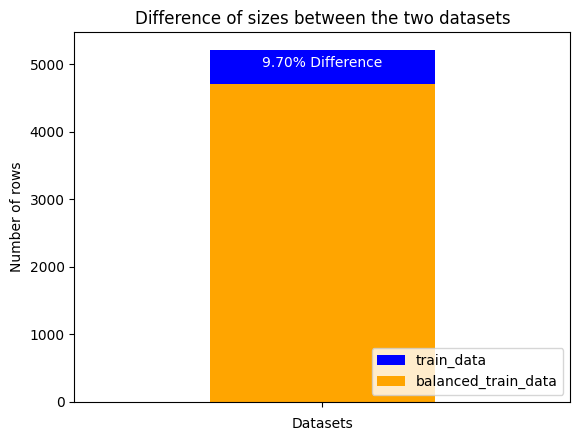

In [10]:
train_data_num_rows = len(train_data)
balanced_train_data_num_rows = len(balanced_train_data)
avg = (train_data_num_rows + balanced_train_data_num_rows) / 2
fig, ax = plt.subplots()

ax.bar([''], [len(train_data), len(balanced_train_data)], width=0.4,label=['train_data', 'balanced_train_data'], color=['blue', 'orange'])
ax.bar([''], [0])
ax.text(0, avg, f"{((1 - (balanced_train_data_num_rows / train_data_num_rows)) * 100):.2f}% Difference", ha='center', color="white")
ax.set_title('Difference of sizes between the two datasets')
ax.legend(loc="lower right")
plt.xlabel('Datasets')
plt.ylabel('Number of rows')
plt.show()

We were able to reduce the gap between the two classes from $49\%$ to $30\%$ by only decreasing the total number of samples by less than $10\%$ which is great. Considering that we have large dataset, this slight decrease shouldn't have any negative effect. 

Now that our data is ready, we will start the training process. 

## Observation

Let's first take a look at the images of the two classes side by side. We will be looking for similarities from within the different classes. We'll take `4` images from each class and display them. 

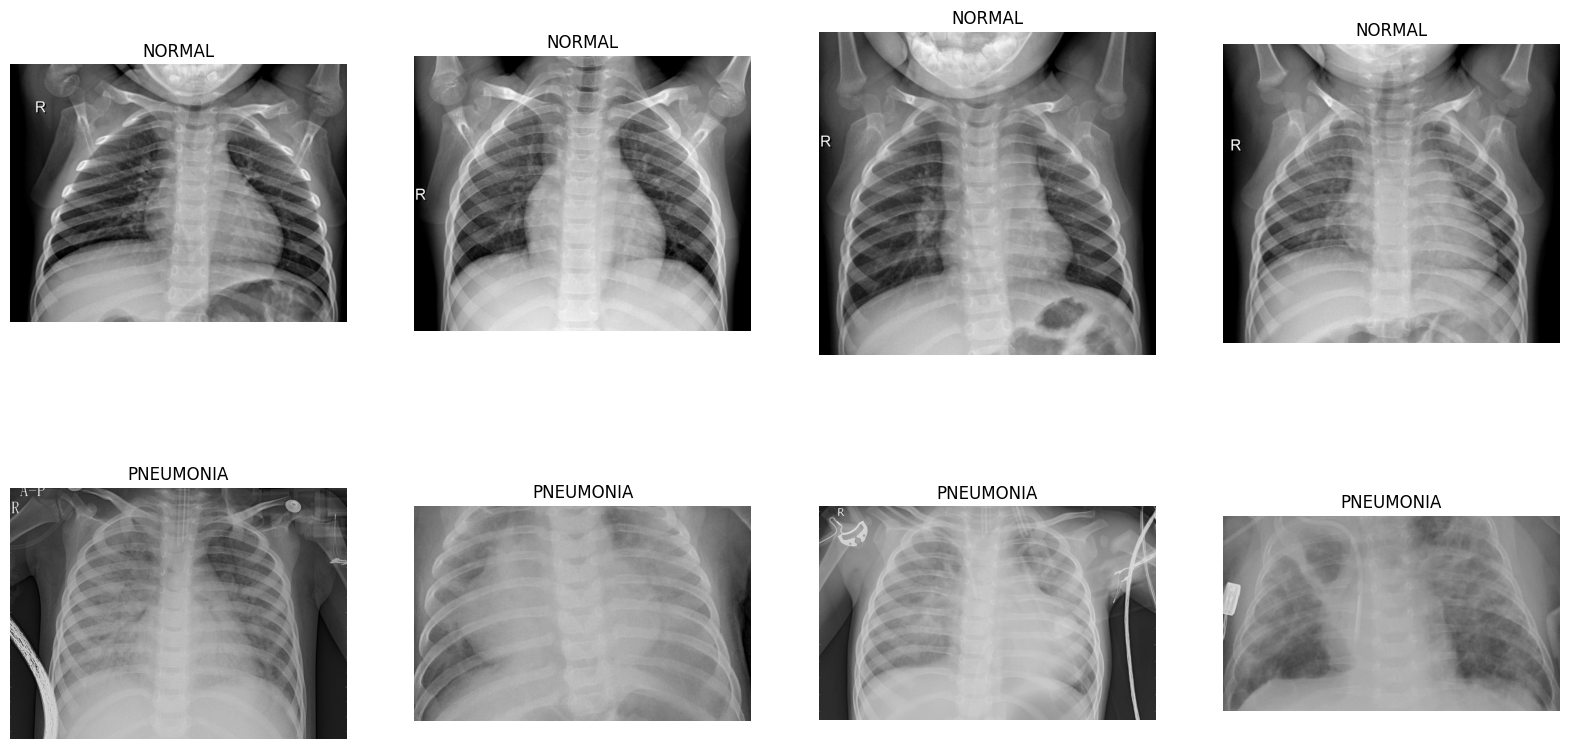

In [11]:
normal_images_sample = balanced_train_data[balanced_train_data["true_label"] == "NORMAL"].head(4).reset_index(drop=True)
pneumonia_images_sample = balanced_train_data[balanced_train_data["true_label"] == "PNEUMONIA"].head(4).reset_index(drop=True)
images_samples = pd.concat([
  normal_images_sample,
  pneumonia_images_sample
]).reset_index(drop=True)

display_images(images_samples, 2, 4)

We can clearly see a pattern between the images in each class. It seems like the x-rays with pneumonia have a larger density of white matter in the lungs which is in most cases located in the middle of the images. So we can think of way to classify these images with this information. To do so we will create the training and test set. Here are the steps that we're gonna go over :

1) Format the images to numpy arrays of greyscale values (ranging from 0 to 255)

2) Center crop the images to remove the outside noise and regularize the images
   
3) Create separate X and Y values (labels)
   
4) Plot the average greyscale value of each image w.r.t it's label hoping to have any grouping

In [83]:
import numpy as np

def preprocess_image(img, target_size=(400, 400), return_type="np"):
  """
  Preprocesses an image by resizing it to the specified target size.
  
  Parameters:
      img (PIL.Image.Image): The input image to be preprocessed.
      target_size (tuple): A tuple specifying the target size (width, height) for the preprocessed image.
      return_type (str): "np" to return a flattened array of the image and else it will return the cropped "pillow" image
  
  Returns:
      PIL.Image.Image: The preprocessed image resized to the target size.
  """
  grayscale_image = img.convert("L")
  resized_image = grayscale_image.resize((500, 500))
  
  crop_coord = get_center_crop_coord(resized_image, target_size)
  
  cropped_image = resized_image.crop(crop_coord)
  
  if return_type == "np":
    return np.array(cropped_image).flatten()
  if return_type == "pillow":
    return cropped_image
  
formatted_images = balanced_train_data['image'].map(lambda x: preprocess_image(x)).reset_index(drop=True)

In the previous code, we format the image and center crop them to narrow down to the essential parts of the scans which are the lungs. We'll demonstrate what the resulting images will look like after processing. 

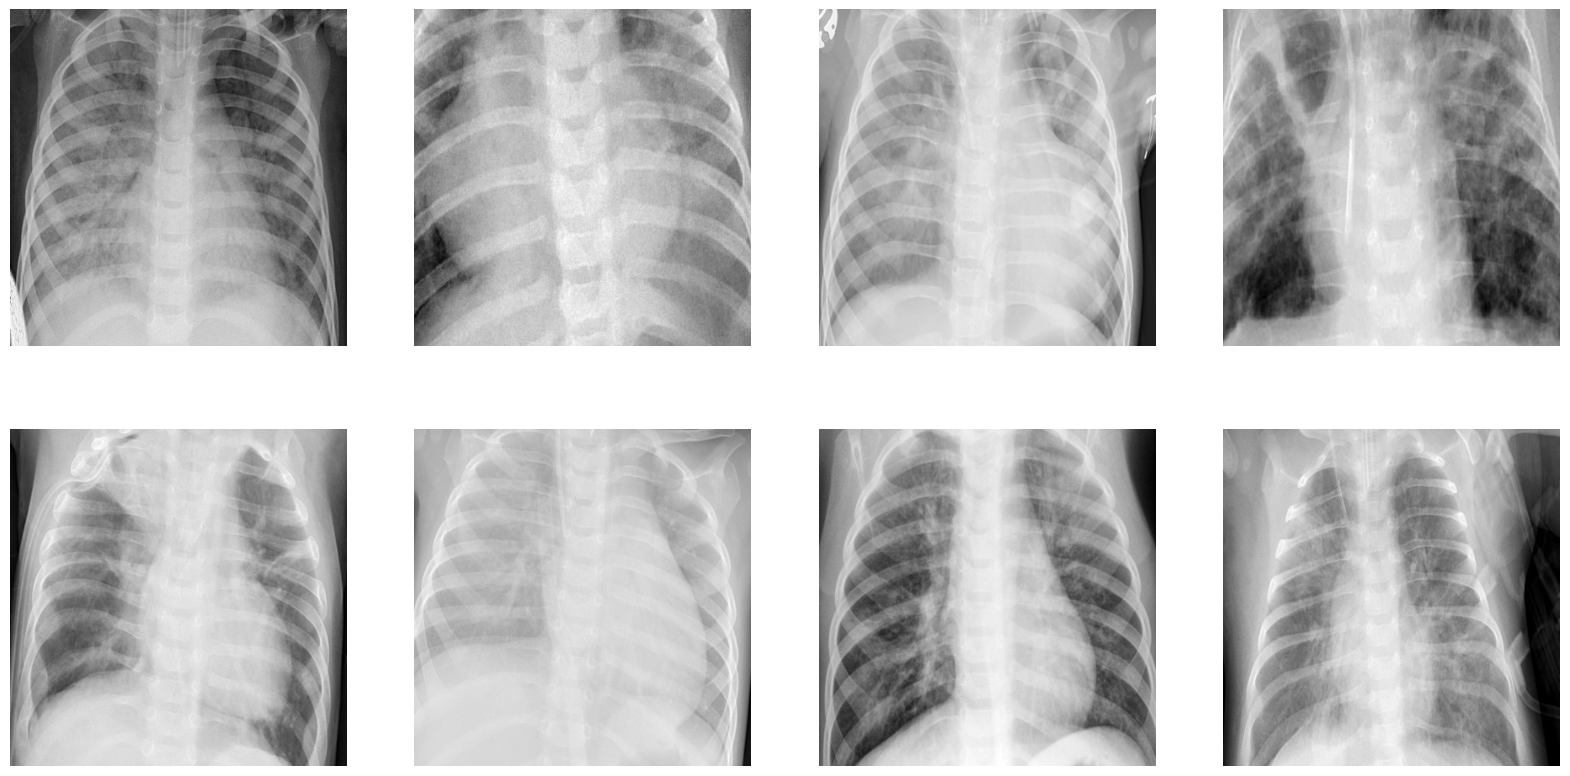

In [84]:
examples = balanced_train_data["image"][:8]

examples = [preprocess_image(img, return_type="pillow") for img in examples]

display_images(examples, 2, 4)